# Cell tower optimization
_2020.06.01_

This notebook prepares the data input files for the cell tower optimization project.

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import json
import requests

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from random import sample, random, randint, getrandbits

tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/zol/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

/home/zol/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



- Go to [OpenCellId](https://opencellid.org/#zoom=16&lat=37.77889&lon=-122.41942),
- Register (user: rhema303@gvnuclear.com password: 2e44d4e2bfab75)
- Download the complete dataset from here: https://unwiredlabs.com/dashboard?ref=opencellid#downloads
- Uncompress and copy the csv to the data subfolder
    - [OpenCellId CSV description](http://wiki.opencellid.org/wiki/Menu_map_view#database)
- Edit the settings below
    - Look up the mobile country code here: https://en.wikipedia.org/wiki/Mobile_country_code

In [2]:
country = 'Slovakia' # name of the country
cell_tower_filename = 'data/cell_towers_2020-05-23-T000000.csv' # the path to the downloaded cell tower CSV
cell_tower_rows_limit = 10_000_000 # number of cell records to be read from the cell tower CSV
mobile_country_code = 231 # Mobile country code
user_count = 10_000 # Number of users to be generated
operator_dict = {
    1: 'Orange Slovensko',
    2: 'Slovak Telekom',
    3: 'SWAN Mobile',
    6: 'O2'
}

# Set it to the center of the country
country_center_lat = 48.75
country_center_lon = 19.73

total_population = 3_000_000 # Set this to increase/decrease the rate of people living in the countryside

radius_city = 0.2 # The spread of the location of the people living in city
radius_country = 1.5 # The spread of the location of the people living in the countryside

date_start = '2020-05-01' # Start date of record generation 
date_end = '2020-05-01' # End date of records generation

OPENCAGEDATA_API_KEY = 'e9990b0d6afa4438a14995b657fd502e' # OpenCageData API key for city to geolocation conversion

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose: print('Memory usage decreased to {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

    return df

## Cell towers generator

**Columns**
- cell_id: unique ID
- radio: technology
- mcc: mobile country code
- net: mobile network code https://www.mcc-mnc.com/
- lat/lon: geolocation
- range: strength of the tower

In [ ]:
pdf_tower = pd.read_csv(cell_tower_filename, nrows=cell_tower_rows_limit)
pdf_tower = pdf_tower[pdf_tower['mcc'] == mobile_country_code].copy()
pdf_tower = pdf_tower[['radio', 'net', 'area', 'cell', 'lat', 'lon', 'range']].copy()

pdf_tower = reduce_mem_usage(pdf_tower)
print('Loaded {:,} records and {:} features.'.format(
    pdf_tower.shape[0],
    pdf_tower.shape[1]
))

In [ ]:
pdf_tower.rename(columns={'radio': 'technology', 'net': 'operator_name'}, inplace=True)

In [ ]:
pdf_tower.replace({
    "operator_name": operator_dict
}, inplace=True)

In [ ]:
pdf_tower['operator_name'].value_counts(sort=False)

In [ ]:
pdf_tower['range'].describe()

In [ ]:
def unique_id():
    seed = getrandbits(16)
    while True:
        yield seed
        seed += 1

unique_sequence = unique_id()

uids = []
for i in range(len(pdf_tower)):
    uids.append(hex(next(unique_sequence))[2:])

In [ ]:
pdf_tower['cell_id'] = uids

In [ ]:
pdf_tower[['cell_id', 'operator_name', 'technology', 'lat', 'lon', 'range']][:5]

In [ ]:
pdf_tower[['cell_id', 'operator_name', 'technology', 'lat', 'lon', 'range']].to_csv('data/{:}_cell_towers.csv'.format(country.lower()), index=False)
print('`data/{:}_cell_towers.csv` written'.format(country.lower()))

**Output format**
- 0: cell_id
- 1: operator_id
- 2: technology
- 3: lat
- 4: lon
- 5: strength

In [ ]:
fig = plt.figure(figsize = (25, 5))
ax = fig.gca()

pdf_tower[pdf_tower['range'] < 50000]['range'].hist(ax=ax, bins=30)

In [ ]:
with open('html/public/json/{:}.json'.format(country.lower()), 'w') as output:
    output.write('var data = [')
    for i in tqdm(range(len(pdf_tower))):
        output.write("['{:}', '{:}', '{:}', {:}, {:}, {:.0f}], ".format(
            pdf_tower.iloc[i]['cell_id'],
            pdf_tower.iloc[i]['operator_name'],
            pdf_tower.iloc[i]['technology'],
            pdf_tower.iloc[i]['lat'],
            pdf_tower.iloc[i]['lon'],
            pdf_tower.iloc[i]['range']
        ))
    output.write(']')

print('`html/public/json/{:}.json` written'.format(country.lower()))

In [ ]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure(go.Scattermapbox(
        lat=pdf_tower['lat'].values,
        lon=pdf_tower['lon'].values,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[country],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=country_center_lat,
            lon=country_center_lon
        ),
        pitch=0,
        zoom=6
    )
)

fig.show()

Go to `html` subfolder and edit `index.html` according to the list below:

- _Line 8_: `<title>Cell towers of Slovakia</title>` - change the name of country to the selected
- _Line 88_: `.setView([48.7575287, 19.7304966], 8)` - change the value of the location to the center of the selected country
- _Line 89_: `.setMaxBounds([[49.7, 16.7], [47.7, 22.6]]);` - change the values of the bounding box to incorporate the country

Save the file, then double click it to view the result in the browser.

<figure class="image">
  <img src='images/map_1.png' description='On country level, the cell towers are merged'>
  <figcaption><center>Merged cell towers on country level</center></figcaption>
</figure>

<figure class="image">
  <img src='images/map_2.png' description='The cell towers are clickable'>
  <figcaption><center>Click the cell towers for the info popup</center></figcaption>
</figure>

<figure class="image">
  <img src='images/map_3.png' description='The cell towers can be toggled with button'>
  <figcaption><center>Toggle the cell towers by clicking the technology selector button in the top right corner</center></figcaption>
</figure>

## User table and CDR generator
Downloading the major cities of Slovakia to be the focal points of the user generation. This snippet might needs alteration for a country other than Slovakia.

In [ ]:
pdf_big_cities = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Slovakia')[0]
pdf_big_cities = pdf_big_cities[['City or town', 'Population 2018']].copy()
pdf_big_cities.rename(columns={'City or town': 'city', 'Population 2018': 'population'}, inplace=True)
pdf_big_cities.sort_values(by='population', ascending=False, inplace=True)

In [ ]:
def get_geolocation(city):
    output = 'Unknown'
    response = requests.get('https://api.opencagedata.com/geocode/v1/json?q={:}&key={:}'.format(
        city,
        OPENCAGEDATA_API_KEY
    ))

    if response.status_code == 200:
        json_string = json.loads(response.content)
        output = json_string['results'][0]['geometry']['lat'], json_string['results'][0]['geometry']['lng']
    else:
        print('Response status: '.format(
            response.status_code
        ))

    return output

pdf_big_cities['latlon'] = pdf_big_cities.progress_apply(lambda x: get_geolocation(x['city']), axis=1)

In [ ]:
def parse_list(list_string, index):
    return float(list_string[index])

pdf_big_cities['lat'] = pdf_big_cities.apply(lambda x: parse_list(x['latlon'], 0), axis=1)
pdf_big_cities['lon'] = pdf_big_cities.apply(lambda x: parse_list(x['latlon'], 1), axis=1)

In [ ]:
pdf_big_cities[['city', 'population', 'lat', 'lon']][:5]

In [ ]:
pdf_big_cities[['city', 'population', 'lat', 'lon']].to_csv('data/{:}_cities.csv'.format(country.lower()), index=False)

### Generate users
Creation of the user table

In [ ]:
def random_point_around(lat, lon, distance):
    t = np.random.normal(0.0, 2.0*np.pi)
    r = distance * np.sqrt(abs(np.random.normal(0.1, 1.0)))
    x = lat + r * np.cos(t)
    y = lon + r * np.sin(t)

    return x, y

In [ ]:
pdf_big_cities = pd.read_csv('data/{:}_cities.csv'.format(country.lower()))

In [ ]:
pdf_big_cities = pdf_big_cities.append({
    'city': 'country',
    'population': total_population-pdf_big_cities['population'].sum(),
    'lat': 49.2, # top right corner
    'lon': 18.0
}, ignore_index=True)

In [ ]:
pdf_big_cities['rate'] = pdf_big_cities['population']/total_population
pdf_big_cities['rate_cumsum'] = pdf_big_cities['rate'].cumsum()

In [ ]:
pdf_big_cities[['city', 'rate', 'rate_cumsum', 'lat', 'lon']][-5:]

In [ ]:
pdf_users = pd.DataFrame(columns=['city', 'lat', 'lon'])

for i in tqdm(range(user_count)):
    random_rate = random()
    random_city = pdf_big_cities[
            (random_rate <= pdf_big_cities['rate_cumsum'])
        ]['city'].values[0]

    if random_city == 'country':
        lat, lon = random_point_around(pdf_big_cities[pdf_big_cities['city'] == random_city]['lat'].values[0], pdf_big_cities[pdf_big_cities['city'] == random_city]['lon'].values[0], radius_country)
    else:
        lat, lon = random_point_around(pdf_big_cities[pdf_big_cities['city'] == random_city]['lat'].values[0], pdf_big_cities[pdf_big_cities['city'] == random_city]['lon'].values[0], radius_city)

    pdf_users = pdf_users.append({
        'city': random_city,
        'lat': lat,
        'lon': lon
    }, ignore_index=True)

In [ ]:
pdf_users[:5]

In [ ]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure(go.Scattermapbox(
        lat=pdf_users['lat'].values[:500],
        lon=pdf_users['lon'].values[:500],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[country],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=country_center_lat,
            lon=country_center_lon
        ),
        pitch=0,
        zoom=6
    )
)

fig.show()

In [ ]:
print('Number of users generated: {:,}\nRate of people living in the countryside: {:.2f}%'.format(
    len(pdf_users),
    len(pdf_users[pdf_users['city'] == 'country'])/len(pdf_users)*100
))

In [ ]:
pdf_users['msisdn'] = sample(range(1_000_000, 9_999_999), user_count)

In [ ]:
pdf_users[:5]

In [ ]:
pdf_users['city'].value_counts()[:5]

### CDR records generation

#### Distribution tester
Use this chunk of code to create distributions to better fit the needs

In [ ]:
pdf_a = pd.DataFrame(columns=['value'])

for i in range(1000):
    pdf_a = pdf_a.append({
        'value': int(abs(np.random.normal(loc=45, scale=200)))
    }, ignore_index=True)

fig = px.histogram(pdf_a, x="value")
fig.show()

#### Record generator

In [ ]:
def random_date(start, end):
    start, end = pd.Timestamp(start), pd.Timestamp(end)
    delta = (end - start).total_seconds()
    offset = np.random.uniform(0., delta)
    offset = pd.offsets.Second(int(offset))
    t = start + offset
    return t

def random_dates(start, end, pick=10, total=100):
    a = []
    for i in range(total):
        a.append(random_date(start, end))
    
    return sample(a, pick)

In [ ]:
pdf_cdr = pd.DataFrame(columns=['msisdn', 'datetime', 'lat', 'lon', 'duration', 'category'])
for date in pd.date_range(start=date_start, end=date_end):
    print(date.strftime('%Y-%m-%d'))
    for user_id in tqdm(range(user_count)):
        call_count = int(abs(np.random.normal(loc=1))*5)
        random_times = random_dates(str(date)[:10] + ' 00:00', str(date)[:10] + ' 23:45', call_count)
        for call_datetime in random_times:
            rnd_lat, rnd_lon = random_point_around(pdf_users.iloc[user_id]['lat'], pdf_users.iloc[user_id]['lon'], 0.01)
            pdf_cdr = pdf_cdr.append({
                'msisdn': pdf_users.iloc[user_id]['msisdn'],
                'datetime': call_datetime,
                'lat': rnd_lat,
                'lon': rnd_lon,
                'duration': int(abs(np.random.normal(loc=45, scale=200))),
                'category': randint(1, 5)
            }, ignore_index=True)    

CDR table
- MSISDN: the ID of the user (aka phone number)
- datetime: the datetime of the call
- lat/lon: geolocation of the starting point of the call
- duration: the duration of the call in seconds
- category: price category of the call

In [ ]:
pdf_cdr[:5]

In [ ]:
pdf_cdr.to_csv('data/{:}_cdr_{:}_{:}.csv'.format(
    country.lower(),
    date_start,
    date_end
), index=False)

In [ ]:
pdf_cdr = reduce_mem_usage(pdf_cdr)
print('CDR records generated: {:,}'.format(
    len(pdf_cdr)
))

Showing the first 500 CDRs on map

In [ ]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure(go.Scattermapbox(
        lat=pdf_cdr['lat'].values[:500],
        lon=pdf_cdr['lon'].values[:500],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=[country],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=country_center_lat,
            lon=country_center_lon
        ),
        pitch=0,
        zoom=6
    )
)

fig.show()

## Technical scores of towers

Metrics used:
- downlink
- packet loss

In [4]:
pdf_tower = pd.read_csv('data/{:}_cell_towers.csv'.format(
    country.lower()
))

pdf_tower = reduce_mem_usage(pdf_tower)
print('Cell tower set contains: {:,} records with {:} features'.format(
    pdf_tower.shape[0],
    pdf_tower.shape[1]
))

Memory usage decreased to  1.08 MB (8.3% reduction)
Cell tower set contains: 25,817 records with 6 features


In [5]:
pdf_cdr = pd.read_csv('data/{:}_cdr_{:}_{:}.csv'.format(
    country.lower(),
    date_start,
    date_end
), parse_dates=['datetime'])

pdf_cdr = reduce_mem_usage(pdf_cdr)
print('CDR set contains: {:,} records with {:} features'.format(
    pdf_cdr.shape[0],
    pdf_cdr.shape[1]
))

Memory usage decreased to  1.95 MB (20.8% reduction)
CDR set contains: 53,820 records with 6 features


In [6]:
pdf_tower['technology'].unique()

array(['GSM', 'UMTS', 'LTE'], dtype=object)

In [35]:
technology_metrics = {
    'GSM': {
        'downlink': 384, # kbps
        'packet_loss_range': [0.3, 0.85]
    },
    'UMTS': {
        'downlink': 42_000, # 42 Mbps
        'packet_loss_range': [0.25, 0.8]
    },
    'LTE': {
        'downlink': 3_000_000, # 3 Gbps
        'packet_loss_range': [0.1, 0.7]
    }
}

### Counting users in range

In [36]:
def count_users_in_range(lat, lon, threshold_lat=0.01, threshold_lon=0.01):
    return len(pdf_cdr[
        (lat - threshold_lat <= pdf_cdr['lat']) &
        (pdf_cdr['lat'] <= lat + threshold_lat) &
        (lon - threshold_lon <= pdf_cdr['lon']) &
        (pdf_cdr['lon'] <= lon + threshold_lon)
    ])
    
pdf_tower['users_in_range'] = pdf_tower.progress_apply(lambda x: count_users_in_range(x['lat'], x['lon']), axis=1)

100%|██████████| 25817/25817 [01:06<00:00, 387.36it/s]


In [37]:
pdf_tower[['cell_id', 'technology', 'operator_name', 'lat', 'lon', 'range', 'users_in_range']][:5]

,cell_id,technology,operator_name,lat,lon,range,users_in_range
0,679f,GSM,Orange Slovensko,48.095963,17.122099,13223,31
1,67a0,GSM,Orange Slovensko,48.085608,17.108707,5805,19
2,67a1,GSM,Orange Slovensko,48.108076,17.095604,3934,25
3,67a2,GSM,Orange Slovensko,48.099289,17.103798,3802,41
4,67a3,GSM,Orange Slovensko,48.140072,17.075835,4876,33


In [38]:
print('Rate of cell towers with no user in range: {:.2f}%'.format(
    len(pdf_tower[pdf_tower['users_in_range'] == 0]['users_in_range'])/len(pdf_tower['users_in_range'])*100
))

Rate of cell towers with no user in range: 21.62%


In [39]:
pdf_tower['users_in_range'].value_counts(sort=True)[:5]

0    5582
1    2307
2    1737
3    1562
4    1383
Name: users_in_range, dtype: int64

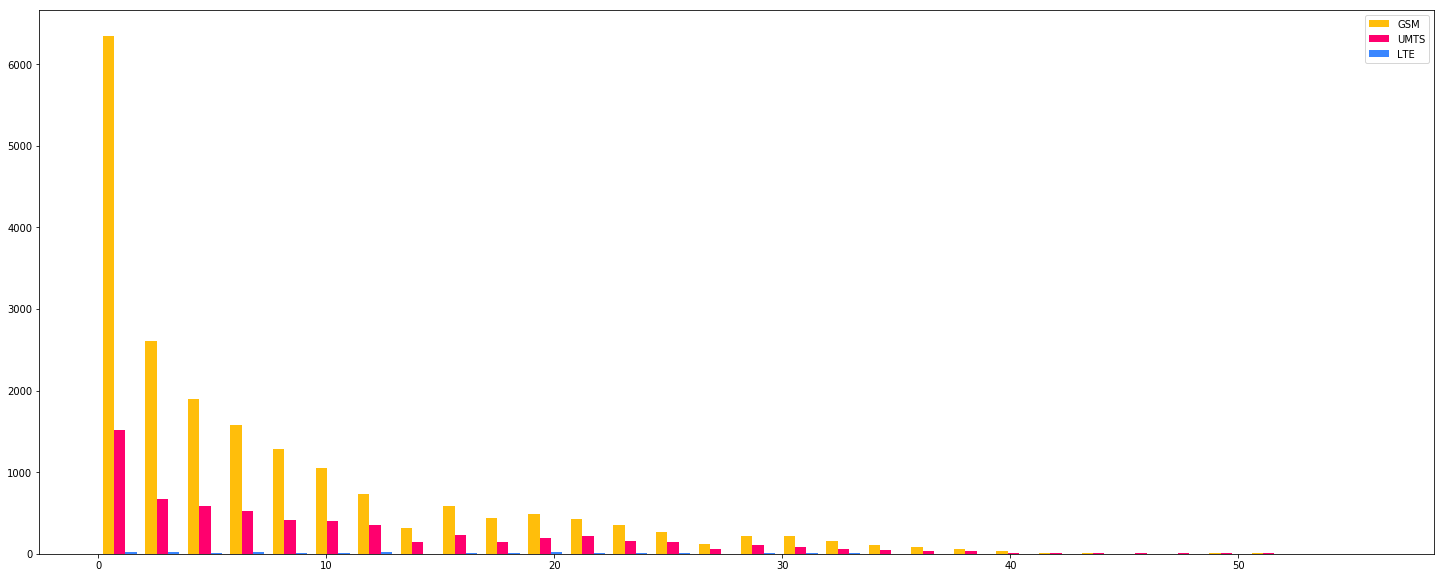

In [40]:
plt.style.use('seaborn-deep')
fig = plt.figure(figsize = (25, 10))
ax = fig.gca()

plt.hist([
    pdf_tower[pdf_tower['technology'] == 'GSM']['users_in_range'],
    pdf_tower[pdf_tower['technology'] == 'UMTS']['users_in_range'],
    pdf_tower[pdf_tower['technology'] == 'LTE']['users_in_range']
], bins=30, label=['GSM', 'UMTS', 'LTE'], color=['#ffbe0b', '#ff006e', '#3a86ff'], stacked=False)
plt.legend(loc='upper right')
plt.show()

### Functions

In [41]:
def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def generate_clamped_normal_value(minimum, maximum):
    return clamp(minimum, (maximum + minimum)/2 + (maximum - minimum)*np.random.normal(loc=0, scale=0.15), maximum)

def generate_tower_statistics(cell_id):
    cell_index = pdf_tower[pdf_tower['cell_id'] == cell_id].index
    cell_technology = pdf_tower.loc[cell_index, 'technology'].values[0]

    downlink = int(generate_clamped_normal_value(
        0,
        technology_metrics[cell_technology]['downlink']
    ))

    packet_loss = round(generate_clamped_normal_value(
        technology_metrics[cell_technology]['packet_loss_range'][0],
        technology_metrics[cell_technology]['packet_loss_range'][1]
    ), 2)

    # the number of users of the cell is correlated with the downlink and less packet loss
    return downlink, packet_loss

### Testing

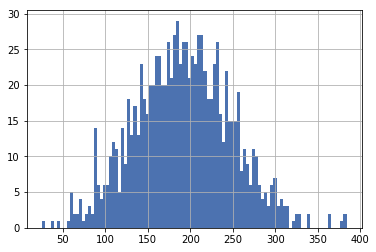

In [42]:
pdf_tmp = pd.DataFrame(columns={'value'})
for i in range(1000):
    pdf_tmp = pdf_tmp.append({
        'value': generate_clamped_normal_value(0, technology_metrics['GSM']['downlink'])
    }, ignore_index=True)

pdf_tmp['value'].hist(bins=100)

In [51]:
generate_tower_statistics(pdf_tower.iloc[0]['cell_id'])

(159, 0.56)

### Data generation

In [43]:
pdf_tower['downlink'],  pdf_tower['packet_loss'] = zip(*pdf_tower.progress_apply(lambda x: generate_tower_statistics(x['cell_id']), axis=1))

100%|██████████| 25817/25817 [01:07<00:00, 383.79it/s]


In [44]:
pdf_tower[:5]

,cell_id,operator_name,technology,lat,lon,range,users_in_range,downlink,packet_loss
0,679f,Orange Slovensko,GSM,48.095963,17.122099,13223,31,262,0.59
1,67a0,Orange Slovensko,GSM,48.085608,17.108707,5805,19,171,0.63
2,67a1,Orange Slovensko,GSM,48.108076,17.095604,3934,25,226,0.51
3,67a2,Orange Slovensko,GSM,48.099289,17.103798,3802,41,144,0.42
4,67a3,Orange Slovensko,GSM,48.140072,17.075835,4876,33,186,0.54


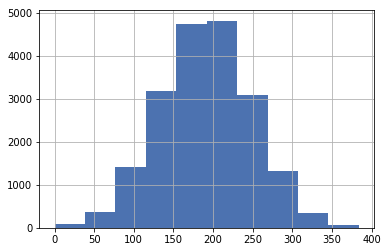

In [45]:
pdf_tower[pdf_tower['technology'] == 'GSM']['downlink'].hist()

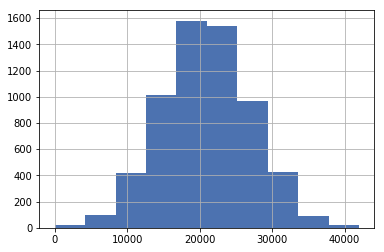

In [46]:
pdf_tower[pdf_tower['technology'] == 'UMTS']['downlink'].hist()

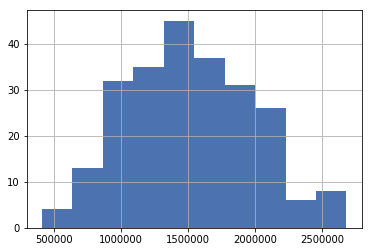

In [47]:
pdf_tower[pdf_tower['technology'] == 'LTE']['downlink'].hist()

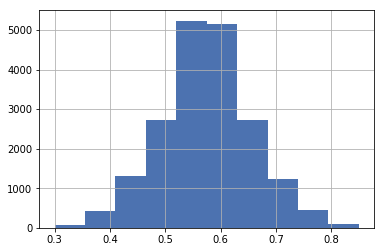

In [48]:
pdf_tower[pdf_tower['technology'] == 'GSM']['packet_loss'].hist()

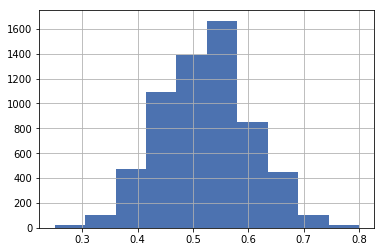

In [49]:
pdf_tower[pdf_tower['technology'] == 'UMTS']['packet_loss'].hist()

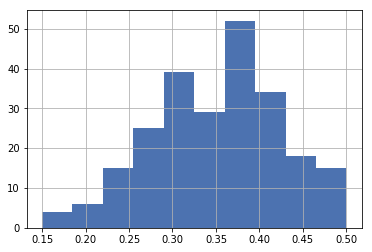

In [50]:
pdf_tower[pdf_tower['technology'] == 'LTE']['packet_loss'].hist()

In [52]:
pdf_tower[:5]

,cell_id,operator_name,technology,lat,lon,range,users_in_range,downlink,packet_loss
0,679f,Orange Slovensko,GSM,48.095963,17.122099,13223,31,262,0.59
1,67a0,Orange Slovensko,GSM,48.085608,17.108707,5805,19,171,0.63
2,67a1,Orange Slovensko,GSM,48.108076,17.095604,3934,25,226,0.51
3,67a2,Orange Slovensko,GSM,48.099289,17.103798,3802,41,144,0.42
4,67a3,Orange Slovensko,GSM,48.140072,17.075835,4876,33,186,0.54


In [54]:
pdf_tower[['cell_id', 'downlink', 'packet_loss']].to_csv('data/{:}_cell_tower_statistics.csv'.format(country.lower()), index=False)
print('`data/{:}_cell_tower_statistics.csv` written'.format(country.lower()))

`data/slovakia_cell_tower_statistics.csv` written
